# Chat Intents

## UMAP + HDBSCAN

In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

import matplotlib.pyplot as plt

import hdbscan
import umap
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

import random
from tqdm.notebook import tqdm, trange
from functools import partial
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
from sentence_transformers import SentenceTransformer

## Load data and pre-trained models

In [4]:
data_sample = pd.read_csv('../data/processed/data_sample.csv')
data_sample.head()

,Unnamed: 0,text,category,cleaned_text
0,1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,im worried card might lost mail long usually take arrive
1,9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,got charged fee shouldnt cash
2,9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,charge making withdrawal took money account earlier charged
3,3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,issue account dont see cheque deposit made yesterday please assist
4,7402,Are there ways for other people to send me money?,receiving_money,way people send money


In [5]:
all_intents = list(data_sample['text'])
len(all_intents)

1000

In [7]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)

print(f"module {module_url} loaded")

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 230.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 450.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 680.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 850.00MB
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [8]:
model_st1 = SentenceTransformer('paraphrase-mpnet-base-v2')
model_st2 = SentenceTransformer('paraphrase-distilroberta-base-v2')
model_st3 = SentenceTransformer('stsb-mpnet-base-v2')

In [9]:
def embed(model, model_type, sentences):
    if model_type == 'use':
        embeddings = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences)
    
    return embeddings

In [10]:
embeddings_use = embed(model_use, 'use', all_intents)
embeddings_use.shape

TensorShape([1000, 512])

In [11]:
embeddings_st1 = embed(model_st1, 'sentence transformer', all_intents)
embeddings_st1.shape

(1000, 768)

In [12]:
embeddings_st2 = embed(model_st2, 'sentence transformer', all_intents)
embeddings_st2.shape

(1000, 768)

In [13]:
embeddings_st3 = embed(model_st3, 'sentence transformer', all_intents)
embeddings_st3.shape

(1000, 768)

## Helper functions

In [44]:
def generate_clusters(message_embeddings, 
                      n_neighbors = 4, 
                      n_components = 5, 
                      min_cluster_size = 4,
                      min_samples = None,
                      random_state = None):
    
    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                metric = 'cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, 
                               min_samples = min_samples,
                               metric='euclidean', 
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)
    
    return clusters

In [88]:
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given cluster supplied from running hdbscan
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

In [100]:
def random_search(embeddings, num_evals):
    space = {
        "n_neighbors": range(3,16),
        "n_components": range(3,16),
        "min_cluster_size": range(2,15)
    }
    
    results = []
    
    for i in trange(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        
        clusters = generate_clusters(embeddings, 
                                     n_neighbors = n_neighbors, 
                                     n_components = n_components, 
                                     min_cluster_size = min_cluster_size, 
                                     #min_samples = min_samples,
                                     random_state = 42)
    
        label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
        
        predicted_labels = clusters.labels_
        ground_labels = data_sample.category
                
        results.append([i, n_neighbors, n_components, min_cluster_size, label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components', 
                                               'min_cluster_size', 'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

In [102]:
def objective(params, embeddings, random_state):
    
    clusters = generate_clusters(embeddings, 
                                 n_neighbors = params['n_neighbors'], 
                                 n_components = params['n_components'], 
                                 min_cluster_size = params['min_cluster_size'], 
                                 random_state = random_state)
    
    label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
    
    #10% penalty on the cost function if outside the desired range of groups
    if (label_count < 30) | (label_count > 100):
        penalty = 0.1 
    else:
        penalty = 0
    
    loss = cost + penalty
    
    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

In [103]:
def bayesian_search(embeddings, max_evals=100):
    
    space = {
        "n_neighbors": hp.choice('n_neighbors', range(3,16)),
        "n_components": hp.choice('n_components', range(3,16)),
        "min_cluster_size": hp.choice('min_cluster_size', range(2,15))
        #"min_samples": hp.choice('min_samples', range(15,35))
    }
    
    trials = Trials()
    fmin_objective = partial(objective, embeddings=embeddings, random_state=42)
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                #algo=partial(tpe.suggest, n_startup_jobs=20),#otherwise the first 20 will be random by default
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    return best_params, trials

In [92]:
def best_clusters(embeddings, best_params):
    clusters_best = generate_clusters(embeddings, 
                                 n_neighbors = best_params['n_neighbors'], 
                                 n_components = best_params['n_components'], 
                                 min_cluster_size = best_params['min_cluster_size'], 
                                 random_state=42)
    
    return clusters_best

In [93]:
def combine_results(data_df, cluster_dict):
    
    #df = pd.DataFrame(all_messages, columns=['message'])
    #df['category'] = all_messages.category

    df = data_df.copy()
    
    for key, value in cluster_dict.items():
        df[key] = value.labels_
    
    return df

In [94]:
def plot_clusters(embeddings, clusters, n_neighbors=4):
    umap_data = umap.UMAP(n_neighbors=n_neighbors, 
                          n_components=2, 
                          min_dist = 0.0, 
                          metric='cosine', 
                          random_state=42).fit_transform(embeddings)

    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters.labels_

    fig, ax = plt.subplots(figsize=(14, 8))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color = '#BDBDBD', s=4)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=4, cmap='hsv_r')
    plt.colorbar()
    plt.show()

In [95]:
def comparison_table(model_dict, results_df):
    summary = []

    for key, value in model_dict.items():
        ari = np.round(adjusted_rand_score(results_df['category'].values, results_df[value].values), 3)
        nmi = np.round(normalized_mutual_info_score(results_df['category'].values, results_df[value].values), 3)
        summary.append([key, ari, nmi])

    comparison_df = pd.DataFrame(summary, columns=['Model','ARI', 'NMI'])
    
    return comparison_df

## Tuning hyperparameters

### Random hyperparameter search

In [96]:
%%time
random_use = random_search(embeddings_use, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 6min 14s, sys: 12.2 s, total: 6min 27s
Wall time: 6min 23s


In [99]:
random_use.head(10)

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost,ari,nmi
93,93,12,4,13,2,0.000,0.002,0.073
12,12,13,8,13,2,0.000,0.002,0.073
65,65,5,9,14,5,0.006,0.005,0.163
84,84,14,5,14,7,0.031,0.015,0.309
16,16,6,11,2,136,0.095,0.266,0.759
77,77,5,8,2,155,0.107,0.216,0.742
76,76,11,14,6,37,0.123,0.218,0.671
91,91,5,3,3,109,0.126,0.228,0.737
43,43,11,3,2,120,0.130,0.216,0.732
83,83,8,3,3,100,0.133,0.232,0.738


### Bayesian optimization with Hyperopt

In [104]:
best_params_use, trials_use = bayesian_search(embeddings_use, max_evals=100)

100%|██████████| 100/100 [05:24<00:00,  3.25s/trial, best loss: 0.083]
best:
{'min_cluster_size': 4, 'n_components': 14, 'n_neighbors': 3}
label count: 73


In [105]:
trials_use.best_trial

{'state': 2,
 'tid': 81,
 'spec': None,
 'result': {'loss': 0.083, 'label_count': 73, 'status': 'ok'},
 'misc': {'tid': 81,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'min_cluster_size': [81],
   'n_components': [81],
   'n_neighbors': [81]},
  'vals': {'min_cluster_size': [2], 'n_components': [11], 'n_neighbors': [0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 9, 6, 17, 28, 11, 569000),
 'refresh_time': datetime.datetime(2021, 9, 6, 17, 28, 14, 391000)}

In [108]:
best_params_st1, trials_st1 = bayesian_search(embeddings_st1, max_evals=100)

100%|██████████| 100/100 [06:22<00:00,  3.82s/trial, best loss: 0.067]
best:
{'min_cluster_size': 4, 'n_components': 6, 'n_neighbors': 3}
label count: 91


In [109]:
best_params_st2, trials_st2 = bayesian_search(embeddings_st2, max_evals=100)

100%|██████████| 100/100 [05:56<00:00,  3.57s/trial, best loss: 0.086]             
best:
{'min_cluster_size': 4, 'n_components': 3, 'n_neighbors': 4}
label count: 97


In [110]:
best_params_st3, trials_st3 = bayesian_search(embeddings_st3, max_evals=100)

100%|██████████| 100/100 [06:15<00:00,  3.75s/trial, best loss: 0.085]
best:
{'min_cluster_size': 4, 'n_components': 12, 'n_neighbors': 5}
label count: 76


In [111]:
best_clusters_use = best_clusters(embeddings_use, best_params_use)

In [112]:
best_clusters_st1 = best_clusters(embeddings_st1, best_params_st1)

In [113]:
best_clusters_st2 = best_clusters(embeddings_st2, best_params_st2)

In [114]:
best_clusters_st3 = best_clusters(embeddings_st3, best_params_st3)

## Evaluate clusters

In [115]:
cluster_dict = {'label_use': best_clusters_use, 
                    'label_st1': best_clusters_st1, 
                    'label_st2': best_clusters_st2,
                    'label_st3': best_clusters_st3}

results_df = combine_results(data_sample[['text', 'category']], cluster_dict)
    
results_df.head()

,text,category,label_use,label_st1,label_st2,label_st3
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,41,48,50,25
1,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,34,52,83,33
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,34,52,82,33
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,62,66,84,53
4,Are there ways for other people to send me money?,receiving_money,35,39,67,41


### Visually inspect clusters

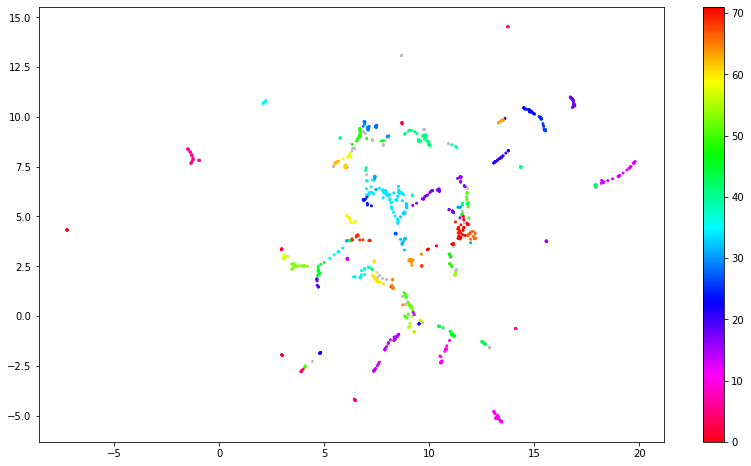

In [116]:
plot_clusters(embeddings_use, best_clusters_use, n_neighbors=4)

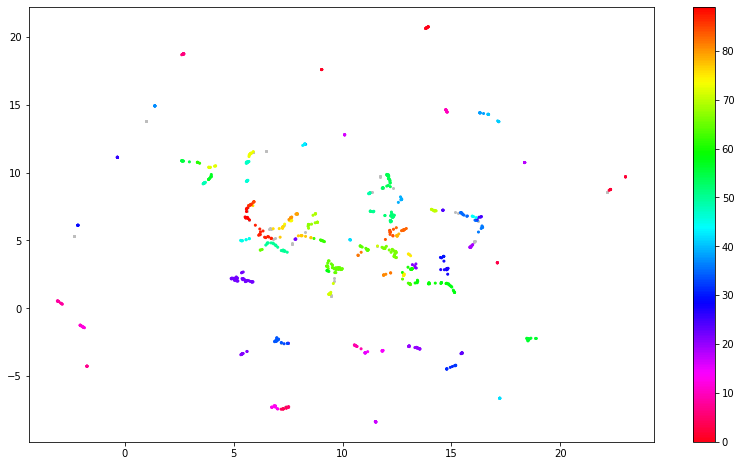

In [117]:
plot_clusters(embeddings_st1, best_clusters_st1, n_neighbors=4)

### Manually inspect category consistency

In [118]:
results_df[results_df['label_use']==2]

,text,category,label_use,label_st1,label_st2,label_st3
100,Help! I need to transfer something to China.,transfer_timing,2,16,56,10
363,I must make a transfer from China and it is urgent. How long before the transfer is complete?,transfer_timing,2,16,56,10
704,I have to quickly transfer something to China. How long will it take to arrive there?,transfer_timing,2,16,56,10
714,How long will it take to transfer something to China urgently?,transfer_timing,2,16,56,10
959,I need to transfer something to China. It is urgent. How many days will it take to get there?,transfer_timing,2,16,56,10


In [119]:
results_df[results_df['category']=='country_support']

,text,category,label_use,label_st1,label_st2,label_st3
11,Do you do business in the EU?,country_support,44,41,24,4
44,What are the countries you have offices in?,country_support,0,40,25,0
122,Can I use this all over the world?,country_support,45,38,44,15
279,What countries are you available in?,country_support,0,40,25,0
295,What are the countries that you operate in?,country_support,0,40,25,0
311,Can I get a card in the EU?,country_support,44,-1,24,4
503,Which countries do you operate in,country_support,0,40,25,0
600,How do I know which countries you provide service in?,country_support,0,40,25,0
724,"I'm not in the UK, but can I still get a card?",country_support,44,-1,24,55
732,Can I get support?,country_support,23,39,-1,46


Both USE and ST1 models have high precision for `country_support` category but also both miss many instances in that group.

In [120]:
results_df[results_df['category']=='card_about_to_expire']

,text,category,label_use,label_st1,label_st2,label_st3
27,"I am overseas in China, can I get a replacement card?",card_about_to_expire,14,-1,-1,-1
370,"If I am in China, can I still order a new card and if so, how?",card_about_to_expire,14,-1,-1,-1
441,My card is almost expired. How fast will I get a new one and what is the cost?,card_about_to_expire,5,73,51,24
477,My card is about to expire. Do I have to go to a branch to order a new card?,card_about_to_expire,5,73,51,24
521,"My card expires soon, will you send me one automatically?",card_about_to_expire,5,73,51,24
524,My card expires very soon. What is the cost and delivery time to get a new one?,card_about_to_expire,5,73,51,24
551,Where can I have a new bank card sent to China?,card_about_to_expire,14,-1,-1,-1
584,How do I get a new expiration date?,card_about_to_expire,5,-1,51,24
605,Are there any express fees if i want my new card faster?,card_about_to_expire,34,73,-1,24
646,My card is almost going to expire.,card_about_to_expire,5,-1,51,24


In [121]:
results_df[results_df['label_st1']==25]

,text,category,label_use,label_st1,label_st2,label_st3
12,"Can I add other people to my account, so they can top up?",topping_up_by_card,45,25,21,30
208,How can my friends top up my account?,topping_up_by_card,-1,25,21,30
549,Show me how can my friends top up my account.,topping_up_by_card,64,25,21,30
673,I want to top up my account. What payment methods are supported?,supported_cards_and_currencies,64,25,21,30
749,Help me to set up contactless payments.,contactless_not_working,68,25,-1,41
909,I want to use a payment card to top up my account. How can I do this?,supported_cards_and_currencies,64,25,21,30


### Compare clustering performance using ground truth labels

In [122]:
model_dict = {'USE': 'label_use', 
              'Sent-Transformer_1': 'label_st1', 
              'Sent-Transformer_2': 'label_st2', 
              'Sent-Transformer_3': 'label_st3'}

comparison_table(model_dict, results_df)

,Model,ARI,NMI
0,USE,0.269,0.714
1,Sent-Transformer_1,0.413,0.785
2,Sent-Transformer_2,0.328,0.770
3,Sent-Transformer_3,0.323,0.748


In [123]:
print(f'use validity: {best_clusters_use.relative_validity_}')
print(f'st1 validity: {best_clusters_st1.relative_validity_}')
print(f'st2 validity: {best_clusters_st2.relative_validity_}')
print(f'st3 validity: {best_clusters_st3.relative_validity_}')

use validity: 0.3508680306713207
st1 validity: 0.36964321882829965
st2 validity: 0.33926156344177416
st3 validity: 0.2946708120799944


### Save cluster results

In [124]:
results_df.to_csv('../data/processed/sample_clustered.csv')

## Applying to the full dataset of 10k intents

In [97]:
data_full = pd.read_csv('../data/raw/train.csv')
data_full.head()

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived after 2 weeks?,card_arrival
2,I have been waiting over a week. Is the card still coming?,card_arrival
3,Can I track my card while it is in the process of delivery?,card_arrival
4,"How do I know if I will get my card, or if it is lost?",card_arrival


In [98]:
all_intents_full = list(data_full['text'])
len(all_intents_full)

10003

In [99]:
embeddings_use = embed(model_use, 'use', all_intents_full)
embeddings_st1 = embed(model_st1, 'sentence transformer', all_intents_full)
embeddings_st2 = embed(model_st2, 'sentence transformer', all_intents_full)
embeddings_st3 = embed(model_st3, 'sentence transformer', all_intents_full)

In [158]:
best_params_use, trials_use = bayesian_search(embeddings_use, max_evals=100)

100%|██████████| 100/100 [17:06<00:00, 10.26s/trial, best loss: 0.13026092172348294]
best:
{'min_cluster_size': 33, 'min_samples': 23, 'n_components': 24, 'n_neighbors': 6}
label count: 51


In [109]:
best_params_use, trials_use = bayesian_search(embeddings_use, max_evals=100)

100%|██████████| 100/100 [14:59<00:00,  9.00s/trial, best loss: 0.11696491052684195]
best:
{'min_cluster_size': 27, 'n_components': 23, 'n_neighbors': 3}
label count: 84


In [110]:
best_params_st1, trials_st1 = bayesian_search(embeddings_st1, max_evals=100)

100%|██████████| 100/100 [16:12<00:00,  9.73s/trial, best loss: 0.09757072878136559]
best:
{'min_cluster_size': 34, 'n_components': 17, 'n_neighbors': 4}
label count: 67


In [111]:
best_params_st2, trials_st2 = bayesian_search(embeddings_st2, max_evals=100)

100%|██████████| 100/100 [19:41<00:00, 11.82s/trial, best loss: 0.09537138858342498]
best:
{'min_cluster_size': 32, 'n_components': 24, 'n_neighbors': 10}
label count: 70


In [112]:
best_params_st3, trials_st3 = bayesian_search(embeddings_st3, max_evals=100)

100%|██████████| 100/100 [17:56<00:00, 10.76s/trial, best loss: 0.13236029191242626]
best:
{'min_cluster_size': 29, 'n_components': 23, 'n_neighbors': 5}
label count: 72


In [113]:
best_clusters_use = best_clusters(embeddings_use, best_params_use)

In [114]:
best_clusters_st1 = best_clusters(embeddings_st1, best_params_st1)

In [115]:
best_clusters_st2 = best_clusters(embeddings_st2, best_params_st2)

In [116]:
best_clusters_st3 = best_clusters(embeddings_st3, best_params_st3)

In [139]:
cluster_dict = {'label_use': best_clusters_use, 
                    'label_st1': best_clusters_st1, 
                    'label_st2': best_clusters_st2,
                    'label_st3': best_clusters_st3}

results_df = combine_results(data_full, cluster_dict)
    
results_df.head()

,text,category,label_use,label_st1,label_st2,label_st3
0,I am still waiting on my card?,card_arrival,41,52,36,27
1,What can I do if my card still hasn't arrived after 2 weeks?,card_arrival,41,52,36,27
2,I have been waiting over a week. Is the card still coming?,card_arrival,41,52,36,27
3,Can I track my card while it is in the process of delivery?,card_arrival,-1,52,36,26
4,"How do I know if I will get my card, or if it is lost?",card_arrival,65,36,36,57


In [142]:
model_dict = {'USE': 'label_use', 
              'Sent-Transformer_1': 'label_st1', 
              'Sent-Transformer_2': 'label_st2', 
              'Sent-Transformer_3': 'label_st3'}

comparison_table(model_dict, results_df)

,Model,ARI,NMI
0,USE,0.253,0.666
1,Sent-Transformer_1,0.300,0.705
2,Sent-Transformer_2,0.320,0.736
3,Sent-Transformer_3,0.262,0.705
